In [1]:
# %load neural_linucb_trainer.py
# python3.7 -m 6_1-disjoint_NeuralLinUCB_trainer.py tpfy-v3-mtl-r2 2026-02-09 --checkpoint 1770723470
import os
os.environ['ENV'] = 'prod'
os.environ['REGION'] = 'apse1'
os.environ['TENANT'] ="in"
os.environ['RECO_S3_BUCKET'] = "p13n-reco-offline-prod"
os.environ['COUNTRY_KEY']= "in"
os.environ['AWS_REGION']= "ap-southeast-1"
os.environ['USE_REAL_CMS3']= "True"
os.environ['RECO_CREDENTIAL']= "-----BEGINRSAPRIVATEKEY-----\nMGICAQACEQCdHOlGnxIMWCMzjK2JAg37AgMBAAECEGOIwGTEO9vd3X9+jyiF4NECCQnoqDakDgSm2QIID9sadWN0XvMCCQLiqPkgVKSuIQIIDCAsWM+pJB8CCQG0jbIGCNX9MA==\n-----ENDRSAPRIVATEKEY-----"

import argparse, gc
import os, time, shutil
import numpy as np
import tensorflow as tf

tfv1 = tf.compat.v1
tfv1.disable_v2_behavior()

# Enable memory growth for GPUs to avoid memory fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

import tensorflow_addons as tfa
import tensorflow_recommenders_addons as tfra
from model.losses import masked_binary_entropy_loss
from model.metrics import MaskedAUC

from common.config.utils import data_path, model_path
from common.config import TENANT
from tpfy.tf_model.tpfy_model_v3_mtl import TpfyModelV3
from omegaconf import OmegaConf
from tpfy.train_v3_mtl import TpfyConfig
from tpfy.helper import load_model_weights_from_s3, create_dataset, save_matrices, load_matrices_from_s3
from common.s3_utils import upload_folder

def load_and_compile_model(args, hparams):
    # Build model
    print(f"\n{'='*80}")
    print("BUILDING MODEL")
    print(f"{'='*80}")

    model = TpfyModelV3(
        hparams.model,
        click_ns=args.click_ns,
        enable_random_watch=hparams.train.enable_random_watch,
    )

    # Create optimizer (needed for compilation, even though we won't train)
    optimizer = tfa.optimizers.AdamW(
        weight_decay=0.0,  # Not needed for inference
        learning_rate=0.001,  # Not needed for inference
        epsilon=1e-4,
    )

    loss_dict = {
            "click": masked_binary_entropy_loss(from_logits=True),
            "watch": masked_binary_entropy_loss(from_logits=True),
            "random_watch": masked_binary_entropy_loss(from_logits=False),
            "paywall_view": masked_binary_entropy_loss(from_logits=True),
            "add_watchlist": masked_binary_entropy_loss(from_logits=True),
    }
    metric_dict = {
            "click": MaskedAUC(from_logits=True),
            "watch": MaskedAUC(from_logits=True),
            "random_watch": MaskedAUC(from_logits=False),
            "paywall_view": MaskedAUC(from_logits=True),
            "add_watchlist": MaskedAUC(from_logits=True),
    }

    optimizer = tfra.dynamic_embedding.DynamicEmbeddingOptimizer(optimizer)

    model.compile(optimizer=optimizer, loss=loss_dict, metrics=metric_dict)
    print("Model compiled")
    
    return model

def compute_A_b(A, b, next_batch, last_layer_tensor, session):
    features, labels, _ = session.run(next_batch)
    
    activation_values = session.run(
        last_layer_tensor,
        feed_dict={} if not features else None  
    )
    y_batch = labels['click']
    mask = (y_batch != -1)

    if not np.any(mask):
        del activation_values, labels, mask
        return A, b

    H = activation_values[mask.squeeze()].copy() 
    y_batch = y_batch[mask].reshape(sum(mask)[0], )
    
    del activation_values, mask  # Delete immediately
    
    H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)
    A += H.T @ H
    b += H.T @ y_batch

    del H, labels, y_batch
    return A, b

2026-02-17 06:31:09.688980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-17 06:31:09.689009: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2026-02-17 06:31:10.706982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-17 06:31:10.707008: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-17 06:31:10.707024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-11-72-173): /proc/driver/nvidia/version does not exist


In [2]:
class Args:
    """Simple class to hold training arguments (replaces argparse)"""
    def __init__(self):
        # Positional arguments
        self.model_name = "tpfy-v3-mtl-r2"
        self.date = "2026-02-06"  # Training date
        self.click_ns = 0.08
        self.lambda_reg = 0.08
        self.variant = "cms3"
        self.batch_size = 512
        self.upload = False  # Set to False if you don't want to upload to S3
        self.clear_nn = False
        self.checkpoint = None
        self.layer_name = 'Relu'
        self.logging_steps = 1000
        self.reset_matrix = False

args = Args()

#     parser = argparse.ArgumentParser(description="TPFY Exploration offline Training.")
#     parser.add_argument("model_name", type=str)
#     parser.add_argument("date", type=str)
#     parser.add_argument("--click_ns", type=float, default=0.08)
#     parser.add_argument("--lambda_reg", type=float, default=1)
#     parser.add_argument("--variant", type=str, default="cms3")
#     parser.add_argument("--batch_size", type=int, default=512)
#     parser.add_argument("--clear_nn", action="store_true", default=False)
#     parser.add_argument("--checkpoint", default=None, type=str)
#     parser.add_argument("--layer_name", default='Relu', type=str)
#     parser.add_argument("--upload", action="store_true", help="uploading model to s3")
#     parser.add_argument("--logging_steps", default=1000, type=int)
#     parser.add_argument("--reset_matrix", action="store_true", default=False)

#     args = parser.parse_args()

# Load configuration
config_name = f"tpfy/tpfy_config/mtl-{TENANT}.yaml"
if not os.path.exists(config_name):
    raise FileNotFoundError(f"Config file {config_name} not found")

hparams: TpfyConfig = OmegaConf.merge(
    OmegaConf.structured(TpfyConfig),
    OmegaConf.load(config_name),
)
print(f"\nLoaded config: {config_name}")

session = tfv1.keras.backend.get_session()
print("Start training")
# run(args, session, hparams)


Loaded config: tpfy/tpfy_config/mtl-in.yaml

Start training


2026-02-17 06:31:11.335398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd
validation_date = args.date
validation_data_path = f's3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/'

tmp = pd.read_parquet(validation_data_path)

In [4]:
tmp.shape[0]/512

9.765625

In [5]:
# def run(args, session, hparams):
validation_date = args.date
validation_data_path = f's3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/'

variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

batch_size = args.batch_size or hparams.train.batch_size

tf_dataset = create_dataset(args.date, variant=variant, batch_size=batch_size, path = validation_data_path)
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()
sample_features, _, _ = session.run(next_batch)
tpfy_model = load_and_compile_model(args=args, hparams=hparams)

_ = tpfy_model(sample_features, training=False)
session.run([
    tfv1.global_variables_initializer(),
    tfv1.local_variables_initializer(),
    tfv1.tables_initializer()
])

plain_weights = load_model_weights_from_s3(
    args.model_name,
    use_s3=True,
    checkpoint_name=args.checkpoint
)
plain_weights_modified = {k.replace('train/', ''): v for k, v in plain_weights.items()}
restore_ops = tpfy_model.restore_plain_weights_ops(
    plain_weights_modified,
    clear_nn=args.clear_nn
)
session.run(restore_ops)

# Create NEW iterator (reset to start of dataset)
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

# Get compress_output tensor (linear_input)
graph = tf.compat.v1.get_default_graph()
compress_output_tensor = graph.get_tensor_by_name(f'tpfy_model_v3/deepfm/{args.layer_name}:0')

d = hparams.model.middle_dim
lambda_ = args.lambda_reg

base_path = f'export/neural_linUCB_offline_matrices_{args.date}'

s3_base_path = model_path(
f"tpfy/tpfy-v3-neural-linucb",
TENANT
)
# s3_base_path = 's3://p13n-reco-offline-prod/upload_objects/test_vedansh'

# Load or initialize matrices
if args.reset_matrix:
    print("Resetting matrices to default initialization")
    A = lambda_ * np.eye(d, dtype=np.float32)
    b = np.zeros((d,), dtype=np.float32)
else:
    print("Loading matrices from previous run")
    s3_latest_path = f"{s3_base_path}/latest_matrices/"
    temp_download_path = "temp/latest_matrices"
    A, b = load_matrices_from_s3(s3_latest_path, temp_download_path, d)

start = time.time()
run_ = 0
os.makedirs(base_path, exist_ok=True)

files s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/dummpy.parquet
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about th

2026-02-17 06:31:14.967030: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499995000 Hz
2026-02-17 06:31:15.012856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)



BUILDING MODEL
Model compiled
--------------
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
q Tensor("tpfy_model_v3/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3/

2026-02-17 06:31:18.381606: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:143] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=32, init_size=8192


Loading matrices from previous run
Downloading: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-neural-linucb/latest_matrices/A.npy -> temp/latest_matrices/A.npy
Download complete. (File temp/latest_matrices/A.npy size 65,664)
Downloading: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-neural-linucb/latest_matrices/b.npy -> temp/latest_matrices/b.npy
Download complete. (File temp/latest_matrices/b.npy size 640)
Successfully loaded matrices from S3: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-neural-linucb/latest_matrices/
A shape: (128, 128), b shape: (128,)


In [21]:
from tqdm import tqdm

iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

for i in (range(5)):
    features, labels, _ = session.run(next_batch)
    print(features['user_fids'].shape)

(512, 27)
(512, 27)
(512, 28)
(512, 27)
(512, 28)


In [24]:
features, labels, _ = session.run(next_batch)
print(features['user_fids'].shape)
activation_values = session.run(
    compress_output_tensor,
    feed_dict={} if not features else None  
)
y_batch = labels['click']
mask = (y_batch != -1)

(512, 28)


In [25]:
activation_values[-1]

array([5.51738203e-01, 2.92818457e-01, 4.20718938e-01, 9.93334889e-01,
       0.00000000e+00, 3.67898524e-01, 9.47939873e-01, 3.54680866e-01,
       8.32596421e-02, 0.00000000e+00, 0.00000000e+00, 2.53886245e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.39405721e-01,
       9.52565193e-01, 3.76139045e-01, 1.16811097e-01, 4.95102674e-01,
       0.00000000e+00, 6.44484937e-01, 0.00000000e+00, 4.09733415e-01,
       0.00000000e+00, 0.00000000e+00, 7.96281159e-01, 0.00000000e+00,
       5.37964642e-01, 5.20399362e-02, 0.00000000e+00, 1.24382451e-01,
       0.00000000e+00, 6.44160435e-02, 1.34461075e-01, 0.00000000e+00,
       0.00000000e+00, 5.05183995e-01, 0.00000000e+00, 6.77130818e-01,
       3.72403741e-01, 2.15819672e-01, 4.40259218e-01, 6.66216969e-01,
       0.00000000e+00, 6.14998877e-01, 8.35623562e-01, 4.11739610e-02,
       4.92595613e-01, 0.00000000e+00, 9.21842933e-01, 8.54505002e-01,
       9.76083949e-02, 9.56190109e-01, 0.00000000e+00, 8.52130175e-01,
      

In [13]:
H = activation_values[mask.squeeze()].copy() 

In [12]:
activation_values.shape, mask.shape, mask.sum()

((512, 128), (512, 1), 424)

In [13]:
mask.shape

(512, 1)

In [14]:
mask.squeeze().shape

(512,)

In [20]:
y_batch = y_batch[mask].reshape(sum(mask)[0], )

IndexError: boolean index did not match indexed array along dimension 0; dimension is 512 but corresponding boolean dimension is 270

In [15]:
activation_values.shape, 

(512, 128)

In [13]:
mask.sum(), mask.shape

(270, (270, 1))

In [9]:
mask.sum(), len(mask)

(399, 512)

In [ ]:
while True:
    if (run_ % args.logging_steps == 0) and (run_):
        save_matrices(base_path, A, b)

        # Upload entire folder to S3 if enabled
        if args.upload:
            upload_folder(f"{s3_base_path}/{args.date}/", base_path, set_acl=False)
            print(f"Uploaded folder to S3: {s3_base_path}/{args.date}/")

        gc.collect()
        print(f'Run {run_} completed in {time.time() - start} s!')
        start = time.time()

    try:
        A, b = compute_A_b(A, b, next_batch, compress_output_tensor, session=session)
    except tf.errors.OutOfRangeError:
        print(f"\nDataset ended at run {run_}. Ending training loop.")
        break
    except Exception as e:
        print(f"\nError at run {run_}: {e}")
        break

    run_ += 1

# Final save
print("\nSaving final matrices...")
save_matrices(base_path, A, b)

if args.upload:
    upload_folder(f"{s3_base_path}/{args.date}/", base_path, set_acl=False)
    upload_folder(f"{s3_base_path}/latest_matrices/", base_path, set_acl=False)
    print(f"Final upload to S3: {s3_base_path}")

    # Cleanup local folders after successful upload
    print("\nCleaning up local folders...")
    if os.path.exists(base_path):
        shutil.rmtree(base_path)
        print(f"Deleted: {base_path}")
    if os.path.exists("temp"):
        shutil.rmtree("temp")
        print(f"Deleted: temp/")

print("\nTraining completed successfully!")
print(f"Final A matrix shape: {A.shape}")
print(f"Final b vector shape: {b.shape}")

In [2]:
import os
os.environ['ENV'] = 'prod'
os.environ['REGION'] = 'apse1'
os.environ['TENANT'] ="in"
os.environ['RECO_S3_BUCKET'] = "p13n-reco-offline-prod"
os.environ['COUNTRY_KEY']= "in"
os.environ['AWS_REGION']= "ap-southeast-1"
os.environ['USE_REAL_CMS3']= "True"
os.environ['RECO_CREDENTIAL']= "-----BEGINRSAPRIVATEKEY-----\nMGICAQACEQCdHOlGnxIMWCMzjK2JAg37AgMBAAECEGOIwGTEO9vd3X9+jyiF4NECCQnoqDakDgSm2QIID9sadWN0XvMCCQLiqPkgVKSuIQIIDCAsWM+pJB8CCQG0jbIGCNX9MA==\n-----ENDRSAPRIVATEKEY-----"

import argparse, gc
import json
import os, time
import numpy as np
import s3fs
import pyarrow
import tensorflow as tf
from tqdm import tqdm

tfv1 = tf.compat.v1
tfv1.disable_v2_behavior()

# Enable memory growth for GPUs to avoid memory fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

import tensorflow_addons as tfa
import tensorflow_recommenders_addons as tfra
from model.losses import masked_binary_entropy_loss
from model.metrics import MaskedAUC

from common.config.utils import data_path, model_path
from common.config import TENANT
from tpfy.tf_model.tpfy_model_v3_mtl import TpfyModelV3, TpfyMtlModelConfig
from tpfy.etl.schema import TpfyMtlDatasetSchema
from model.parquet_dataset import TFParquetDataset
from tpfy.common import TpfyDataPath
from omegaconf import OmegaConf
from dataclasses import dataclass
from tpfy.train_v3_mtl import make_example_mtl, TpfyTrainConfig, TpfyConfig
from tpfy.helper import load_model_weights_from_s3

def create_dataset(date, path = None):
    if path:
        data_path_str = path
    else:
        data_path_str = data_path(
            TpfyDataPath.S3_TPFY_IMPR_V3_DAILY_MTL_EXTRACTED_EXAMPLES, TENANT
        ) % (variant, date)

    dataset = TFParquetDataset([data_path_str], TpfyMtlDatasetSchema, shuffle_files=True)
    tf_dataset = dataset.create_tf_dataset(batch_size).map(make_example_mtl)
    return tf_dataset

def load_and_compile_model():
    # Build model
    print(f"\n{'='*80}")
    print("BUILDING MODEL")
    print(f"{'='*80}")

    model = TpfyModelV3(
        hparams.model,
        click_ns=args.click_ns,
        enable_random_watch=hparams.train.enable_random_watch,
    )

    # Create optimizer (needed for compilation, even though we won't train)
    optimizer = tfa.optimizers.AdamW(
        weight_decay=0.0,  # Not needed for inference
        learning_rate=0.001,  # Not needed for inference
        epsilon=1e-4,
    )

    loss_dict = {
            "click": masked_binary_entropy_loss(from_logits=True),
            "watch": masked_binary_entropy_loss(from_logits=True),
            "random_watch": masked_binary_entropy_loss(from_logits=False),
            "paywall_view": masked_binary_entropy_loss(from_logits=True),
            "add_watchlist": masked_binary_entropy_loss(from_logits=True),
    }
    metric_dict = {
            "click": MaskedAUC(from_logits=True),
            "watch": MaskedAUC(from_logits=True),
            "random_watch": MaskedAUC(from_logits=False),
            "paywall_view": MaskedAUC(from_logits=True),
            "add_watchlist": MaskedAUC(from_logits=True),
    }

    optimizer = tfra.dynamic_embedding.DynamicEmbeddingOptimizer(optimizer)

    model.compile(optimizer=optimizer, loss=loss_dict, metrics=metric_dict)
    print("Model compiled")
    
    return model

def get_activations_and_labels(next_batch, last_layer_tensor):
    features, labels, metadata = session.run(next_batch)
    
    activation_values = session.run(last_layer_tensor)
    
    return activation_values, labels, metadata

def compute_A(A, next_batch, last_layer_tensor):
    activation_values, labels, metadata = get_activations_and_labels(next_batch, last_layer_tensor)
    print(activation_values)
    y_batch = labels['click']
    mask = (y_batch != -1)

    if not np.any(mask):
        del activation_values, labels, metadata, mask
        return A

    H = activation_values[mask.squeeze()].copy() 
    del activation_values, mask  # Delete immediately
    
    H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)
    A += H.T @ H

    del H, labels, metadata 
    return A

def run(args):
    tf_dataset = create_dataset(args.date)
    iterator = tf_dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()
    sample_features, sample_labels, sample_metadata = session.run(next_batch)
    tpfy_model = load_and_compile_model()

    prediction = tpfy_model(sample_features, training=False)
    session.run([
        tfv1.global_variables_initializer(),
        tfv1.local_variables_initializer(),
        tfv1.tables_initializer()
    ])

    plain_weights = load_model_weights_from_s3(
        args.model_name,
        use_s3=True,
        checkpoint_name=args.checkpoint
    )
    plain_weights_modified = {k.replace('train/', ''): v for k, v in plain_weights.items()}
    restore_ops = tpfy_model.restore_plain_weights_ops(
        plain_weights_modified,
        clear_nn=args.clear_nn
    )
    session.run(restore_ops)

    # Create NEW iterator (reset to start of dataset)
    iterator = tf_dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()

    # Get compress_output tensor (linear_input)
    graph = tf.compat.v1.get_default_graph()
    compress_output_tensor = graph.get_tensor_by_name(f'tpfy_model_v3/deepfm/{args.layer_name}:0')

    #train feature matrix
    # lambda_=1.0
    d=128
    # A = lambda_ * np.eye(d, dtype=np.float64)
    A = np.zeros((d,d), dtype=np.float64)

    start = time.time()
    run_ = 0
    os.makedirs(f'tpfy/neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}', exist_ok=True)
    while True:
        if (run_ % 100 == 0) and (run_):
            np.save(f'tpfy/neural_linUCB_offline_matrices_{args.date}_{args.checkpoint}/A_{run_}.npy', A)
            gc.collect()
            print(f'Run {run_} completed in {time.time() - start} s!')
            start = time.time()
        try:
            A = compute_A(A, next_batch, compress_output_tensor)
        except tf.errors.OutOfRangeError:
            print("End of dataset reached")
            break
        run_ += 1
    
class Args:
    """Simple class to hold training arguments (replaces argparse)"""
    def __init__(self):
        # Positional arguments
        self.model_name = "tpfy-v3-mtl-r2"
        self.date = "2026-02-06"  # Training date
        self.click_ns = 0.08
        self.lambda_reg = 0.08
        self.variant = "cms3"
        self.batch_size = 512
        self.upload = False  # Set to False if you don't want to upload to S3
        self.clear_nn = False
        self.checkpoint = None
        self.layer_name = 'Relu'
        self.logging_steps = 1000
        self.reset_matrix = False

args = Args()

# parser = argparse.ArgumentParser(description="TPFY Exploration offline Training.")
# parser.add_argument("model_name", type=str)
# parser.add_argument("date", type=str)
# parser.add_argument("--click_ns", type=float, default=0.08)
# parser.add_argument("--variant", type=str, default="cms3")
# parser.add_argument("--batch_size", type=int, default=512)
# parser.add_argument("--clear_nn", action="store_true", default=False)
# parser.add_argument("--checkpoint", default=None, type=str)
# parser.add_argument("--layer_name", default='Relu', type=str)

# args = parser.parse_args()

# Load configuration
config_name = f"tpfy/tpfy_config/mtl-{TENANT}.yaml"
if not os.path.exists(config_name):
    raise FileNotFoundError(f"Config file {config_name} not found")

hparams: TpfyConfig = OmegaConf.merge(
    OmegaConf.structured(TpfyConfig),
    OmegaConf.load(config_name),
)
print(f"\nLoaded config: {config_name}")

# Override batch size if specified
if args.batch_size:
    hparams.train.batch_size = args.batch_size

batch_size = hparams.train.batch_size
print(f"Batch size: {batch_size}")

# Load dataset
variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

session = tfv1.keras.backend.get_session()
print("Start training")
# run(args)

2026-02-17 12:24:49.973670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-17 12:24:49.973699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2026-02-17 12:24:51.012858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-17 12:24:51.012884: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-17 12:24:51.012898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-11-72-173): /proc/driver/nvidia/version does not exist



Loaded config: tpfy/tpfy_config/mtl-in.yaml
Batch size: 512

Start training


2026-02-17 12:24:51.595269: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
validation_date = args.date
validation_data_path = f's3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/'

variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

batch_size = args.batch_size or hparams.train.batch_size

# Load and compile model FIRST
tpfy_model = load_and_compile_model()

tf_dataset = create_dataset(args.date, path = validation_data_path)

# Build the graph - similar to trainer.py lines 366-375
with tfv1.name_scope("linucb_training"):
    iterator = tf_dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()

    # Unpack - this creates tensor placeholders
    if len(next_batch) == 3:
        x, y_true, metadata = next_batch
    else:
        x, y_true = next_batch
        metadata = None

    # Call model with TENSOR x (not numpy data) - this builds the forward pass in the graph
    y_pred = tpfy_model(x, training=False)

# Initialize all variables
session.run([
    tfv1.global_variables_initializer(),
    tfv1.local_variables_initializer(),
    tfv1.tables_initializer()
])

# Load weights
print(f"\nLoading model weights: {args.model_name}")
plain_weights = load_model_weights_from_s3(
    args.model_name,
    use_s3=True,
    checkpoint_name=args.checkpoint
)
plain_weights_modified = {k.replace('train/', 'linucb_training/'): v for k, v in plain_weights.items()}
restore_ops = tpfy_model.restore_plain_weights_ops(
    plain_weights_modified,
    clear_nn=args.clear_nn
)
session.run(restore_ops)

# NOW get the activation tensor from the graph (AFTER model is called in the graph)
graph = tfv1.get_default_graph()
compress_output_tensor = graph.get_tensor_by_name(
    f'linucb_training/tpfy_model_v3/deepfm/{args.layer_name}:0'
)



BUILDING MODEL
Model compiled
files s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/dummpy.parquet
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in

2026-02-17 12:24:59.098852: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499995000 Hz


Reading checkpoint from: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-mtl-r2/checkpoint
Using checkpoint: 1771324540
Loading weights from: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-mtl-r2/1771324540/plain_weights.npz
Loaded 18 weight tensors
Weight keys: ['train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/query_dense/kernel:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/query_dense/bias:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/key_dense/kernel:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/key_dense/bias:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/kernel_full_0:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/kernel_compact_0:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/bias_0:0', 'train/tpfy_model_v3/deepfm/compress_dense/kernel:0', 'train/tpfy_model_v3/deepfm/compress_dense/bias:0', 'train/tpfy_model_v3/deepfm/linear/linear_bias:0']...
reload source keys
linucb_training/tpfy_model_v3/feature_prep/d

2026-02-17 12:25:00.047810: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:143] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=32, init_size=8192


In [18]:
x, y_true, metadata = next_batch

features_val, labels_val, metadata_val, pred_values, activation_val = session.run(
    [x, y_true, metadata, y_pred, compress_output_tensor]
)

labels_val['click'][0]

array([0.], dtype=float32)

In [19]:
features_val['user_fids'][0]

array([  18010442820927642,   26282751487100903,   30473928018519015,
         38752548480567183,   52558572850079295,   60339255362303347,
         71729434137426642,   75490802718027078,   86474907716623441,
         94110082929227526,  105771320358320486,  112421516648451837,
        117997908582961592, 1109496150758225693,  132396849400231283,
       1800972323576723103,  135107988821114881, 1055810764324444956,
       1051910021140670741, 1098878309078401029, 1124351450060244810,
       1134497528617814517, 1873497444986126344, 1882504644240867331,
        989639971461820696, 1817877897957910065,                   0,
                         0])

In [20]:
activation_val[0][:10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.802481  , 0.        , 0.        , 0.47637665],
      dtype=float32)

In [21]:
target_output = activation_val @ plain_weights_modified['linucb_training/tpfy_model_v3/deepfm/linear/linear_kernel:0'] + plain_weights_modified['linucb_training/tpfy_model_v3/deepfm/mtl_linear/linear_bias:0']
target_output[0]

array([-0.12409385,  0.13100815], dtype=float32)

In [22]:
click_biases = plain_weights_modified['linucb_training/tpfy_model_v3/click_biases:0'][0]
target_output[0, 0:1] + click_biases - pred_values['click'][0]

array([-0.21691632], dtype=float32)

In [23]:
click_biases = plain_weights_modified['linucb_training/tpfy_model_v3/click_biases:0'][1]
target_output[0, 0:1] + click_biases - pred_values['click'][0]

array([1.9888763], dtype=float32)

In [46]:
np.load('default_matrices/latest_matrices/A.npy')

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [58]:
import io
import boto3

def save_matrices_to_s3(s3_path, A, b):
    """Save matrices directly to S3 without local storage."""
    s3_client = boto3.client('s3')
    
    # Parse S3 path
    if s3_path.startswith('s3://'):
        s3_path = s3_path[5:]
    bucket_name = s3_path.split('/')[0]
    prefix = '/'.join(s3_path.split('/')[1:])
    
    # Save A matrix
    A_buffer = io.BytesIO()
    np.save(A_buffer, A)
    A_buffer.seek(0)
    s3_client.upload_fileobj(A_buffer, bucket_name, f"{prefix}/A.npy")
    print(f"Uploaded A matrix to s3://{bucket_name}/{prefix}/A.npy")
    
    # Save b vector
    b_buffer = io.BytesIO()
    np.save(b_buffer, b)
    b_buffer.seek(0)
    s3_client.upload_fileobj(b_buffer, bucket_name, f"{prefix}/b.npy")
    print(f"Uploaded b vector to s3://{bucket_name}/{prefix}/b.npy")
    
    A_buffer.close()
    b_buffer.close()

def load_matrices_from_s3_direct(s3_path):
    """Load matrices directly from S3 without local download."""
    s3_client = boto3.client('s3')
    
    # Parse S3 path
    if s3_path.startswith('s3://'):
        s3_path = s3_path[5:]
    bucket_name = s3_path.split('/')[0]
    prefix = '/'.join(s3_path.split('/')[1:])
    
    # try:
        # Load A matrix
    A_buffer = io.BytesIO()
    s3_client.download_fileobj(bucket_name, f"{prefix}/A.npy", A_buffer)
    A_buffer.seek(0)
    A = np.load(A_buffer)
    A_buffer.close()

    # Load b vector
    b_buffer = io.BytesIO()
    s3_client.download_fileobj(bucket_name, f"{prefix}/b.npy", b_buffer)
    b_buffer.seek(0)
    b = np.load(b_buffer)
    b_buffer.close()

    print(f"Loaded matrices from s3://{bucket_name}/{prefix}/")
    return A, b
    # except Exception as e:
    #     print(f"Could not load matrices from S3: {e}")
    #     print("Initializing new matrices...")
    #     A = np.eye(d, dtype=np.float32)
    #     b = np.zeros((d,), dtype=np.float32)
    #     return A, b

In [59]:
A = np.load('default_matrices/latest_matrices/A.npy')
b = np.load('default_matrices/latest_matrices/b.npy')

In [67]:
s3_base_path = 's3://p13n-reco-offline-prod/upload_objects/test_vedansh/latest_matrices'

In [61]:
save_matrices_to_s3(s3_base_path, A, b)

Uploaded A matrix to s3://p13n-reco-offline-prod/upload_objects/test_vedansh/2025-02-16//A.npy
Uploaded b vector to s3://p13n-reco-offline-prod/upload_objects/test_vedansh/2025-02-16//b.npy


In [68]:
A_, b_ = load_matrices_from_s3_direct(s3_base_path)

Loaded matrices from s3://p13n-reco-offline-prod/upload_objects/test_vedansh/latest_matrices/


In [69]:
s3_base_path = model_path(
f"tpfy/tpfy-v3-neural-linucb",
TENANT
)

In [70]:
s3_base_path

's3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-neural-linucb'

In [72]:
model_path("tpfy/neural-linucb-matrices", TENANT)

's3://p13n-reco-offline-models-prod/models/tpfy/neural-linucb-matrices'

<h3>Debugging end of sequence error and handling it in code</h3>

In [1]:
# python3.7 -m 6_1-disjoint_NeuralLinUCB_trainer.py tpfy-v3-mtl-r2 2026-02-09 --checkpoint 1770723470
import os
os.environ['ENV'] = 'prod'
os.environ['REGION'] = 'apse1'
os.environ['TENANT'] ="in"
os.environ['RECO_S3_BUCKET'] = "p13n-reco-offline-prod"
os.environ['COUNTRY_KEY']= "in"
os.environ['AWS_REGION']= "ap-southeast-1"
os.environ['USE_REAL_CMS3']= "True"
os.environ['RECO_CREDENTIAL']= "-----BEGINRSAPRIVATEKEY-----\nMGICAQACEQCdHOlGnxIMWCMzjK2JAg37AgMBAAECEGOIwGTEO9vd3X9+jyiF4NECCQnoqDakDgSm2QIID9sadWN0XvMCCQLiqPkgVKSuIQIIDCAsWM+pJB8CCQG0jbIGCNX9MA==\n-----ENDRSAPRIVATEKEY-----"

# python3.7 -m 6_1-disjoint_NeuralLinUCB_trainer.py tpfy-v3-mtl-r2 2026-02-09 --checkpoint 1770723470
import argparse, gc
import os, time, shutil
import numpy as np
import tensorflow as tf

tfv1 = tf.compat.v1
tfv1.disable_v2_behavior()

# Enable memory growth for GPUs to avoid memory fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

import tensorflow_addons as tfa
import tensorflow_recommenders_addons as tfra
from model.losses import masked_binary_entropy_loss
from model.metrics import MaskedAUC

from common.config.utils import data_path, model_path
from common.config import TENANT
from tpfy.tf_model.tpfy_model_v3_mtl import TpfyModelV3
from omegaconf import OmegaConf
from tpfy.common import TpfyDataPath
from tpfy.train_v3_mtl import TpfyConfig
from tpfy.helper import load_model_weights_from_s3, create_dataset, save_matrices_to_s3, load_matrices_from_s3_direct

S3_TPFY_NEURAL_LINUCB_MODEL_EXPORT = model_path(TpfyDataPath.S3_TPFY_NEURAL_LINUCB_MATRICES, TENANT)

def load_and_compile_model(args, hparams):
    """
    Docstring for load_and_compile_model
    
    :param args: hyperparameters and arguments for model loading and compilation
    :param hparams: hyperparameters and arguments for model loading and compilation
    """
    # Build model
    print(f"\n{'='*80}")
    print("BUILDING MODEL")
    print(f"{'='*80}")

    model = TpfyModelV3(
        hparams.model,
        click_ns=args.click_ns,
        enable_random_watch=hparams.train.enable_random_watch,
    )

    # Create optimizer (needed for compilation, even though we won't train)
    optimizer = tfa.optimizers.AdamW(
        weight_decay=0.0,  # Not needed for inference
        learning_rate=0.001,  # Not needed for inference
        epsilon=1e-4,
    )

    loss_dict = {
            "click": masked_binary_entropy_loss(from_logits=True),
            "watch": masked_binary_entropy_loss(from_logits=True),
            "random_watch": masked_binary_entropy_loss(from_logits=False),
            "paywall_view": masked_binary_entropy_loss(from_logits=True),
            "add_watchlist": masked_binary_entropy_loss(from_logits=True),
    }
    metric_dict = {
            "click": MaskedAUC(from_logits=True),
            "watch": MaskedAUC(from_logits=True),
            "random_watch": MaskedAUC(from_logits=False),
            "paywall_view": MaskedAUC(from_logits=True),
            "add_watchlist": MaskedAUC(from_logits=True),
    }

    optimizer = tfra.dynamic_embedding.DynamicEmbeddingOptimizer(optimizer)

    model.compile(optimizer=optimizer, loss=loss_dict, metrics=metric_dict)
    print("Model compiled")
    
    return model

def compute_A_b(A, b, next_batch, last_layer_tensor, session):
    """
    Docstring for compute_A_b
    
    :param A: Covariance matrix A to be updated : (B, d, d)
    :param b: Response vector b to be updated : (B, d)
    :param next_batch: iterator batch containing features, labels, and metadata tensors
    :param last_layer_tensor: Activation tensor from the last layer of the neural network to be used as context features for LinUCB
    :param session: TensorFlow session for running the computation
    """
    features, labels, metadata = next_batch
    
    features, labels, _, activation_values = session.run(
        [features, labels, metadata, last_layer_tensor]
    )
    y_batch = labels['click']
    mask = (y_batch != -1)

    if not np.any(mask):
        del activation_values, labels, mask
        return A, b

    H = activation_values[mask.squeeze()].copy() 
    y_batch = y_batch[mask].reshape(sum(mask)[0], )
    
    del activation_values, mask  # Delete immediately
    
    H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)

    # A is computed using the outer product of the features (H) and b is computed using the product of features 
    # and rewards (y_batch)
    A += H.T @ H
    b += H.T @ y_batch

    del H, labels, y_batch, features, metadata
    return A, b

2026-02-17 11:27:13.469663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-17 11:27:13.469692: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2026-02-17 11:27:14.678346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-17 11:27:14.678374: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-17 11:27:14.678389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-11-72-173): /proc/driver/nvidia/version does not exist


In [2]:
class Args:
    """Simple class to hold training arguments (replaces argparse)"""
    def __init__(self):
        # Positional arguments
        self.model_name = "tpfy-v3-mtl-r2"
        self.date = "2026-02-06"  # Training date
        self.click_ns = 0.08
        self.lambda_reg = 0.08
        self.variant = "cms3"
        self.batch_size = 512
        self.upload = False  # Set to False if you don't want to upload to S3
        self.clear_nn = False
        self.checkpoint = None
        self.layer_name = 'Relu'
        self.logging_steps = 1000
        self.reset_matrix = False

args = Args()

config_name = f"tpfy/tpfy_config/mtl-{TENANT}.yaml"
if not os.path.exists(config_name):
    raise FileNotFoundError(f"Config file {config_name} not found")

hparams: TpfyConfig = OmegaConf.merge(
    OmegaConf.structured(TpfyConfig),
    OmegaConf.load(config_name),
)
print(f"\nLoaded config: {config_name}")

session = tfv1.keras.backend.get_session()
print("Start training")


Loaded config: tpfy/tpfy_config/mtl-in.yaml

Start training


2026-02-17 11:27:16.672671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# def run(args, session, hparams):
variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

batch_size = args.batch_size or hparams.train.batch_size

tf_dataset = create_dataset(args.date, variant=variant, batch_size=batch_size, 
                            path = f's3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/')
tpfy_model = load_and_compile_model(args=args, hparams=hparams)

with tfv1.name_scope("linucb_training"):
    iterator = tf_dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()

    # Unpack - this creates tensor placeholders
    if len(next_batch) == 3:
        x, y_true, metadata = next_batch
    else:
        x, y_true = next_batch
        metadata = None

    y_pred = tpfy_model(x, training=False)

session.run([
    tfv1.global_variables_initializer(),
    tfv1.local_variables_initializer(),
    tfv1.tables_initializer()
])

# last trained DeepFM model checkpoint is loaded here to extract last layer representations as features for LinUCB.
plain_weights = load_model_weights_from_s3(
    args.model_name,
    use_s3=True,
    checkpoint_name=args.checkpoint
)

# The keys in plain_weights have the format 'train/layer_name/weight_name'. 
# We need to modify them to match the current model's scope, which is 'linucb_training/tpfy_model_v3/deepfm/layer_name/weight_name'
plain_weights_modified = {k.replace('train/', 'linucb_training/'): v for k, v in plain_weights.items()}
restore_ops = tpfy_model.restore_plain_weights_ops(
    plain_weights_modified,
    clear_nn=args.clear_nn
)
session.run(restore_ops)

# Create NEW iterator (reset to start of dataset)
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

# Getting the tensor for the specified layer's activations to be used as features for LinUCB
# Here, extracting the output Relu(SparseFeaturesOutput + DenseFeaturesOutput). This is given to Linear layer(d, 2) to predict click and watch logits.
graph = tfv1.get_default_graph()
compress_output_tensor = graph.get_tensor_by_name(
    f'linucb_training/tpfy_model_v3/deepfm/{args.layer_name}:0'
)
d = hparams.model.middle_dim
lambda_ = args.lambda_reg

s3_base_path = S3_TPFY_NEURAL_LINUCB_MODEL_EXPORT
# s3_base_path = 's3://p13n-reco-offline-prod/upload_objects/test_vedansh'

# Load or initialize matrices
if args.reset_matrix:
    print("Resetting matrices to default initialization")
    A = lambda_ * np.eye(d, dtype=np.float32)
    b = np.zeros((d,), dtype=np.float32)
else:
    print("Loading matrices from previous run")
    s3_latest_path = f"{s3_base_path}/latest_matrices"
    A, b = load_matrices_from_s3_direct(s3_latest_path)

files s3://p13n-reco-offline-prod/upload_objects/test_vedansh/daily-mtl-extracted-cms3-minimum-5-contents/tmp/dummpy.parquet
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead

BUILDING MODEL
Model compiled
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in

2026-02-17 11:27:21.590717: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499995000 Hz


Reading checkpoint from: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-mtl-r2/checkpoint
Using checkpoint: 1771324540
Loading weights from: s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-mtl-r2/1771324540/plain_weights.npz
Loaded 18 weight tensors
Weight keys: ['train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/query_dense/kernel:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/query_dense/bias:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/key_dense/kernel:0', 'train/tpfy_model_v3/feature_prep/dot_prod_attention_pooling/key_dense/bias:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/kernel_full_0:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/kernel_compact_0:0', 'train/tpfy_model_v3/deepfm/dnn/dnn_hyb/bias_0:0', 'train/tpfy_model_v3/deepfm/compress_dense/kernel:0', 'train/tpfy_model_v3/deepfm/compress_dense/bias:0', 'train/tpfy_model_v3/deepfm/linear/linear_bias:0']...
reload source keys
linucb_training/tpfy_model_v3/feature_prep/d

2026-02-17 11:27:22.651545: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:143] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=32, init_size=8192


Loading matrices from previous run
Loaded matrices from s3://p13n-reco-offline-models-prod/models/tpfy/tpfy-v3-neural-linucb/latest_matrices/


In [4]:
import pandas as pd
tmp = pd.read_parquet('dummpy.parquet')
tmp.shape[0]/512

9.765625

In [5]:
last_layer_tensor = compress_output_tensor

In [16]:
run_ = 10
try:
    features, labels, metadata = next_batch

    features, labels, _, activation_values = session.run(
        [features, labels, metadata, last_layer_tensor]
    )
    y_batch = labels['click']
    mask = (y_batch != -1)

    H = activation_values[mask.squeeze()].copy() 
    y_batch = y_batch[mask].reshape(sum(mask)[0], )

    # del activation_values, mask  # Delete immediately

    H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)

    # A is computed using the outer product of the features (H) and b is computed using the product of features 
    # and rewards (y_batch)
    A += H.T @ H
    b += H.T @ y_batch
    print(y_batch.shape, mask.sum(), activation_values.shape, H.shape)
except tf.errors.OutOfRangeError:
    print(f"\nDataset ended at run {run_}. Ending training loop.")


Dataset ended at run 10. Ending training loop.


In [41]:
y_batch.shape, mask.sum(), activation_values.shape, H.shape

((392, 1), 352)

((392, 128), (352, 128))

In [48]:
import pandas as pd
x = pd.read_pickle('progressive_matrices/reseted/validation_dumping_dict_2026-02-05/validation_stats_run_100.pkl')
# x = pd.read_pickle('corrected_validation/validation_dumping_dict_2026-02-11/validation_stats_run_0.pkl')

In [49]:
len(set(x['deepFMpredictions']))

51170

In [34]:
x['variances'][512]

0.0039353613

In [40]:
result_dict = pd.read_pickle(f'corrected_validation//validation_dumping_dict_2026-02-09/validation_stats_run_0.pkl')

In [46]:
result_dict.keys()

dict_keys(['dw_p_ids', 'timestamps', 'content_ids', 'deepFMpredictions', 'labels', 'variances', 'means'])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

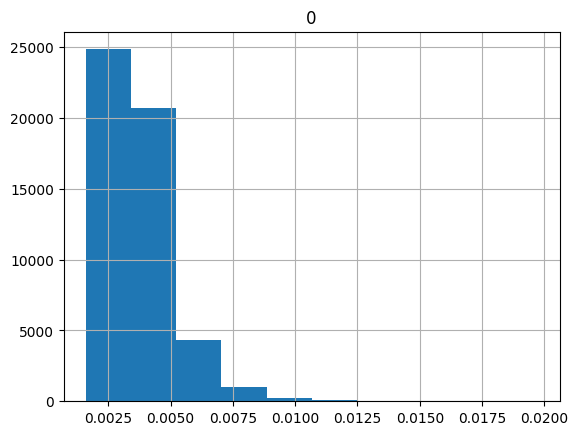

In [44]:
pd.DataFrame(x['variances']).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

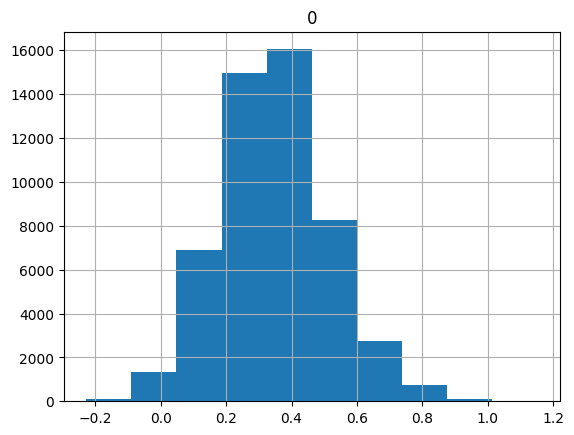

In [45]:
pd.DataFrame(x['means']).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

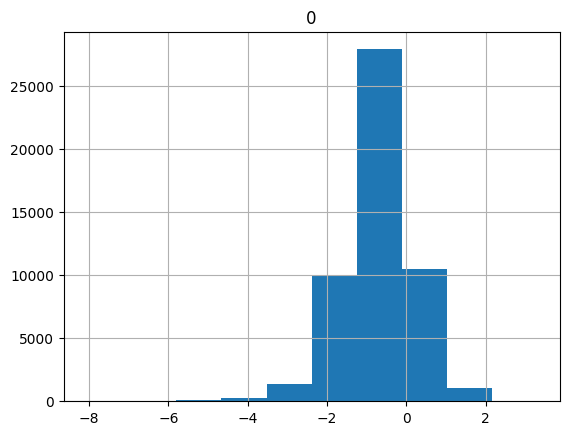

In [47]:
pd.DataFrame(x['deepFMpredictions']).hist()

In [ ]:
A, b = compute_A_b(A, b, next_batch, compress_output_tensor, session=session)